In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import dlib
from keras.utils import to_categorical,normalize
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
face_detector = dlib.get_frontal_face_detector()
from keras.applications.xception import preprocess_input
from keras import models
from statistics import *

Import the saved Model 

In [ ]:
model_Xc = models.load_model('/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/model_finetuned_xception.hdf5')

In [ ]:
model_Xc1 = models.load_model('/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/model_finetuned_xception.hdf5') #


Evaluation of test data on model.

In [ ]:
#Import the test data for evaluation
x_test=joblib.load('/content/drive/MyDrive/Hashim/Final/x_test.pkl')
y_test=joblib.load('/content/drive/MyDrive/Hashim/Final/y_test.pkl')
print("Done")

Done


In [ ]:
print("Shape of Test data {}".format(x_test.shape))

Shape of Test data (5050, 299, 299, 3)


In [ ]:
Y_test=to_categorical(y_test)

In [ ]:
print (len(y_test))

5050


In [ ]:
#Evaluate the model performance on the test data
model_Xc1.evaluate(x_test,Y_test)

158/158 [==============================] - 19s 84ms/step - loss: 0.1973 - accuracy: 0.9465


[0.19727614521980286, 0.9465346336364746]

# Creation of Confusion Matrix for the Test Data

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
model_Xc1.predict_classes(x_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 1, ..., 0, 0, 0])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  999
False positive =  213
False negative =  57
True negative =  3781




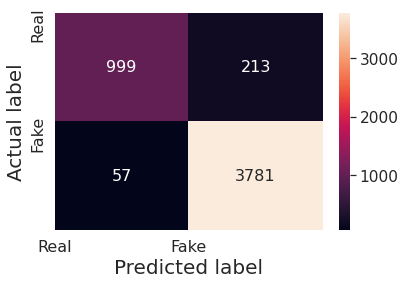

In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Real', 'Fake'], size = 16)
    plt.yticks(np.arange(2), ['Real', 'Fake'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(y_test, model_Xc1.predict_classes(x_test))

From here, this code is used to check whether any video is Deepfake or not.
It follows the following steps:
1. Input video is processed to extract its frames.
2. The facial region is extracted and separated from the input frame.
3. Model evaluate the face and give its confidence value on the face being real and fake.
4. Based on the model's prediction, the facial region in the frame is either marked real and fake along with confidence value.
5. All the frames are then joined back to create the video output with prediction and confidence value on each frame.
6. Final label of the video is also stored in a .txt file.

In [ ]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    #Reference: https://github.com/ondyari/FaceForensics
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left() # Taking lines numbers around face
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # scaling size of box to 1.3
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def get_predicition(image):
    """
    input:      Expects the image input.

    processing: the image further cropped to face and the cropped face image is sent for evalution.
    
    output:     returns the annotated reusult with bounding box around the face. 
    """
    height, width = image.shape[:2]
    try: # If in case face is not detected at any frame
        face = face_detector(image, 1)[0]  # Face detection
        x, y, size = get_boundingbox(face=face, width=width, height=height) # Calling to get bound box around the face
    except IndexError:
        pass
    cropped_face = image[y:y+size, x:x+size] # cropping the face 
    output,label = evaluate(cropped_face) # Sending the cropped face to get classifier result 
    font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
    thickness = 2
    font_scale = 1
    if label=='Real':
        color = (0,255, 0)
    else:
        color = (0, 0, 255)
    x = face.left()    # Setting the bounding box on uncropped image
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    cv2.putText(image, label+'_'+str('%.2f'%output)+'%', (x, y+h+30), 
            font_face, font_scale,
            color, thickness, 2) # Putting the label and confidence values

    return output,label,cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)# draw box over face

def evaluate(cropped_face):
    """This function classifies the cropped  face on loading the trained model
    and 
    returns the label and confidence value
    """        
    img = cv2.resize(cropped_face, (299, 299))#resize the image
    img = np.expand_dims(img, axis=0)#expand its dimension
    img = preprocess_input(img) 
    res = model_Xc.predict(img)[0]#evaluate the image
    #print (res)
    if np.argmax(res)==1:
        label = 'Fake'
    else:
        label = 'Real'
    
    #print("res",res, "max arg",np.argmax(res), "lable", label)
    return res[np.argmax(res)]*100.0, label

def final_model(video_path,limit_frames):
        """
        input:      Expects the video path.
                    limit_frames : total number frames to be taken from input video.

        processing: convert the video into frames and make prediction on each frame individually and returns the lable and confidence value.

        output:     write the video with classification results and write the final lable to a .txt file.
        """
        o_op = []
        l_lb = []
        name_video = video_path.split("/")[-1].split(".")[-2]# take video name
        txt_file  = open("/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/Videos Result/"+name_video+".txt", "w+")#creat a .txt file 
        capture = cv2.VideoCapture(video_path)
        if capture.isOpened():#creat a new video output file
                _,image = capture.read()
                frame_width = int(capture.get(3))
                frame_height = int(capture.get(4))
                out = cv2.VideoWriter('/content/drive/MyDrive/Hashim/MXXCEPTIONFINALMODEL/Xception Fnal Last ry/Videos Result/'+name_video+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))#path of the output file
        else:
                _ = False
        i=1   
        while (_):#evaluate the video 
                _, image = capture.read()
                output,label,classified_img = get_predicition(image)
                #print ("output", output)
                #print ("label", label)
                out.write(classified_img)#output the final video with lable and confidence value
                o_op.append(output)
                l_lb.append(label)                
                if i%10 == 0:
                    print("Number of frames complted:{}".format(i))
                if i==limit_frames:
                        break
                i=i+1
        #write fnal label to the .txt file
        #print (l_lb,o_op)
        lb_rl = l_lb.count('Real')
        lb_fk = l_lb.count('Fake')
        lb_tot = len(l_lb)
        real_per = ((lb_rl/lb_tot)*100 )
        #print (lb_fk,"lb_rl",lb_rl)
        #print ("output is :",o_op)
        #print ("output lenth is :",len(l_lb))
        #print ("label is :",l_lb)
        #print ("lable is :",len(o_op))
        #print ("Real percentage", real_per)
        if real_per >= 85:
          label_vid = 'Real' 
        else:
          label_vid = 'Fake'
        print ("This video "+name_video +" is catagorized as "+label_vid)
        avg = mean(o_op)
        txt_file.write("This video "+name_video +" is catagorized as "+label_vid+'\n')
        txt_file.close() 
        capture.release()

Evaluation of different videos from different creation methods. (video data also provided).

In [ ]:
dir_path = '/content/drive/MyDrive/Hashim/Dataset_for_final_Eval/Videos'
seq = os.listdir(dir_path)
a = len(seq)

In [ ]:
path =(dir_path+'/'+seq[0])

In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[1],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id1_id4_0006 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[2],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id1_id6_0000 is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[3],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id1_id6_0001 is catagorized as Real


In [ ]:

#For testing any new video
final_model(video_path=dir_path+'/'+seq[4],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id2_id0_0000 is catagorized as Fake


In [ ]:

#For testing any new video
final_model(video_path=dir_path+'/'+seq[5],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id1_id35_0006 is catagorized as Fake


In [ ]:

#For testing any new video
final_model(video_path=dir_path+'/'+seq[6],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id3_id28_0008 is catagorized as Fake


In [ ]:

#For testing any new video
final_model(video_path=dir_path+'/'+seq[7],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id3_id30_0001 is catagorized as Fake


In [ ]:

#For testing any new video
final_model(video_path=dir_path+'/'+seq[8],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id3_id31_0000 is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[9],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id3_id28_0009 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[10],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video jawgcggquk is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[11],
            limit_frames=90)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
This video iznnzjvaxc is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[12],
            limit_frames=30)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
This video jzmzdispyo is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[13],
            limit_frames=200)

In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[14],
            limit_frames=90)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
This video orekjthsef is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[15],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 261 is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[16],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 802 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[17],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 047_862 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[18],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 895 is catagorized as Real


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[19],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 991 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[20],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 329_327 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[21],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 663_231 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[22],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 296 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[23],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 827_817 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[24],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 919_015 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[25],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 719_737 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[26],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 679_665 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[27],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 982_004 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[28],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 698_693 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[29],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 962_929 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[30],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 806_781 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[31],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 698_6 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[32],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 719_7 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[33],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 806_7 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[34],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video 962_9 is catagorized as Fake


In [ ]:
#For testing any new video
final_model(video_path=dir_path+'/'+seq[0],
            limit_frames=200)

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
This video id1_id4_0005 is catagorized as Fake
